In [5]:
#モジュールのインポート
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(); sns.set_palette('husl')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial Unicode MS'  # to use Japanese in plots
from pprint import pprint

import keras

In [3]:
df_train = pd.read_csv("./kaggle_data/titanic/train.csv",encoding="utf-8-sig")

In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### カラムの一覧
- PassengerId – 乗客識別ユニークID
- Survived – 生存フラグ（0=死亡、1=生存）
- Pclass – チケットクラス
- Name – 乗客の名前
- Sex – 性別（male=男性、female＝女性）
- Age – 年齢
- SibSp – タイタニックに同乗している兄弟/配偶者の数
- parch – タイタニックに同乗している親/子供の数
- ticket – チケット番号
- fare – 料金
- cabin – 客室番号
- Embarked – 出港地（タイタニックへ乗った港）

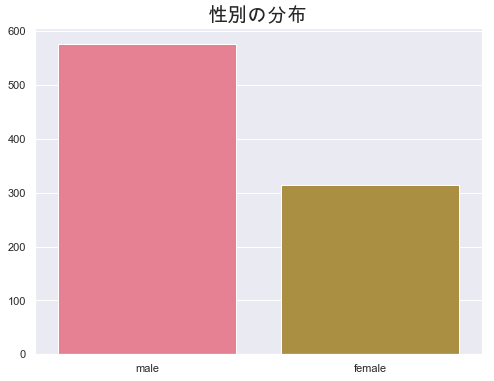

In [8]:
sex_counts = df_train['Sex'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title('性別の分布', fontsize=20)
plt.show()

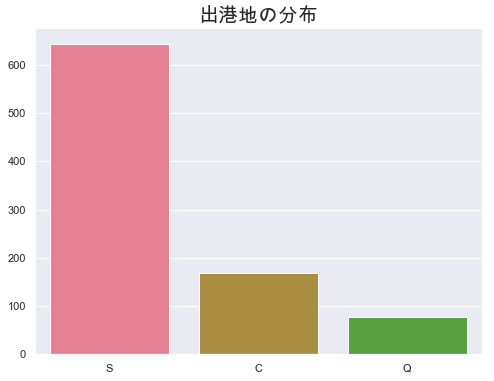

In [12]:
data_counts = df_train['Embarked'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=data_counts.index, y=data_counts.values)
plt.title('出港地の分布', fontsize=20)
plt.show()

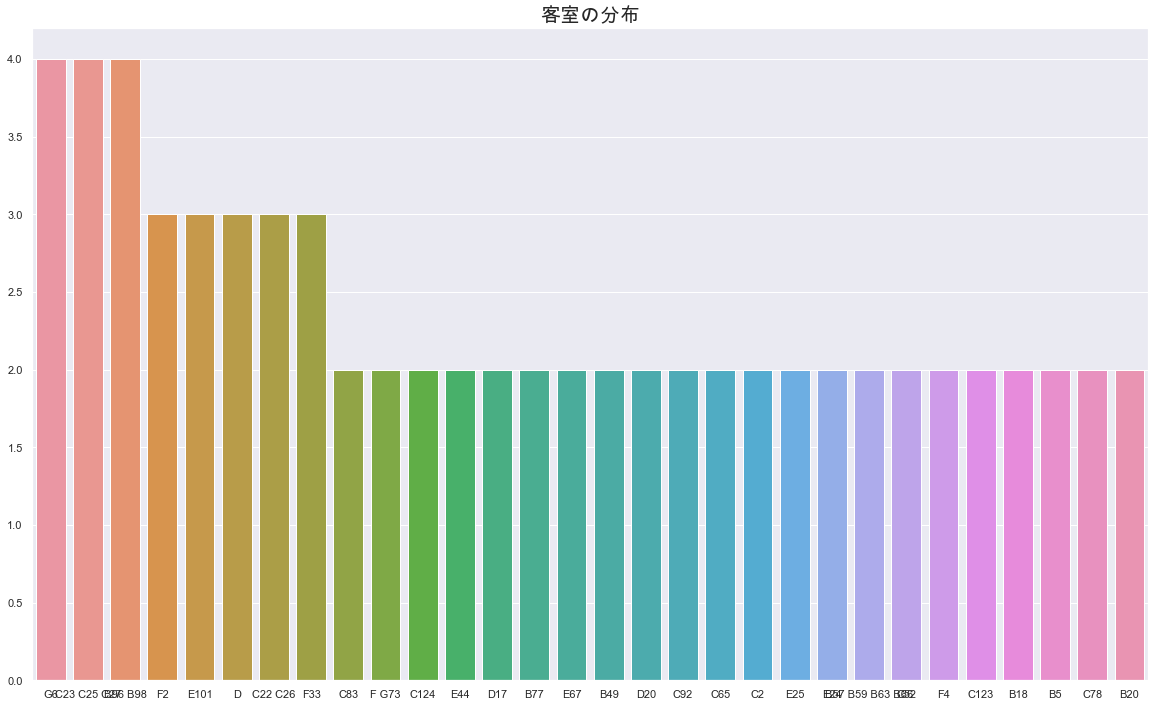

In [27]:
sex_counts = df_train['Cabin'].value_counts()[:30]
plt.figure(figsize=(20, 12))
sns.barplot(x=sex_counts.index, y=sex_counts.values)
plt.title('客室の分布', fontsize=20)
plt.show()

In [21]:
cabin_not_nan =df_train['Cabin'].dropna().index

In [29]:
df_train.iloc[cabin_not_nan]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


In [30]:
df_train["surname"] = df_train["Name"].apply(lambda x:x.split(",")[0])

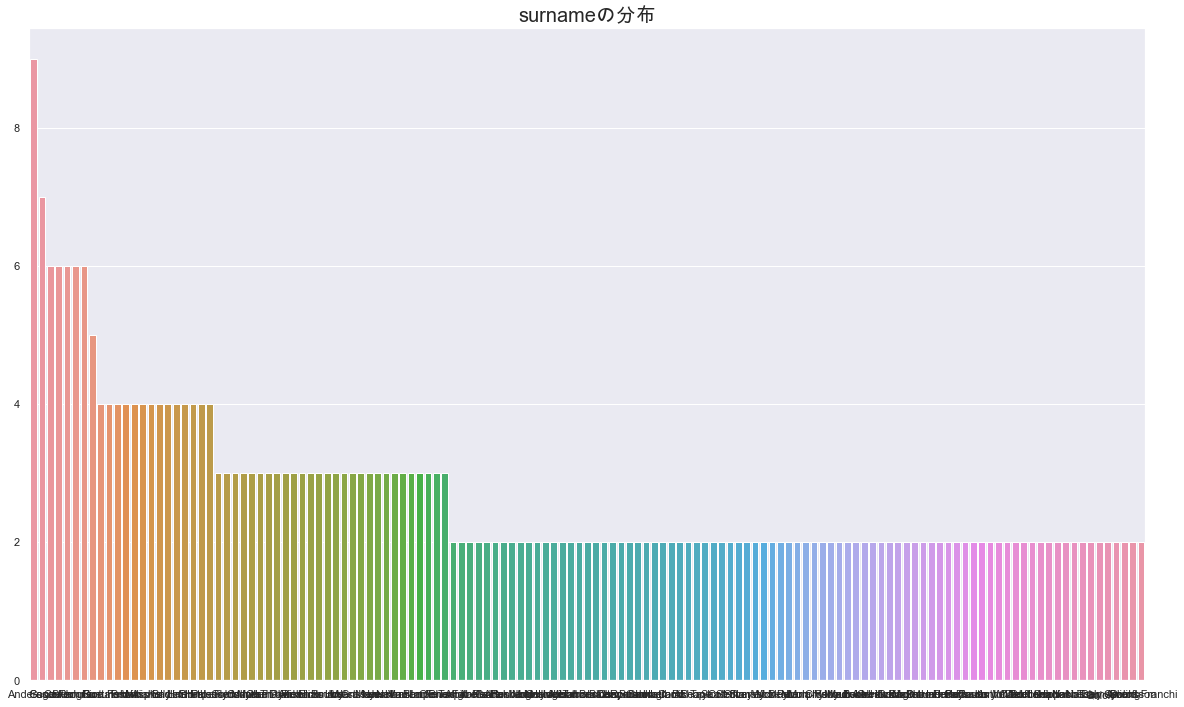

In [62]:
data_counts = df_train['surname'].value_counts()[:133]
plt.figure(figsize=(20, 12))
sns.barplot(x=data_counts.index, y=data_counts.values)
plt.title('surnameの分布', fontsize=20)
plt.show()

In [41]:
df_train[df_train["surname"] == data_counts.index[0]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,Andersson
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Andersson
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,Andersson
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,Andersson
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,Andersson
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,Andersson
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,Andersson
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Andersson
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,Andersson


In [43]:
len(df_train['surname'].unique().tolist())

667

In [51]:
df_train[df_train["surname"] == data_counts.index[-1]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,surname
550,551,1,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,C,Thayer
581,582,1,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39.0,1,1,17421,110.8833,C68,C,Thayer
698,699,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C,Thayer


In [53]:
cols = ["surname"]
df_train_surname_to_cat = pd.get_dummies(df_train, columns=cols)
print(df_train_surname_to_cat.shape)

(891, 679)


In [55]:
df_train_surname_to_cat

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,surname_Yousseff,surname_Yrois,surname_Zabour,surname_Zimmerman,surname_de Messemaeker,surname_de Mulder,surname_de Pelsmaeker,surname_del Carlo,surname_van Billiard,surname_van Melkebeke
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,0,0,0,0,0,0,0,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,0,0,0,0,0,0,0,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,0,0,0,0,0,0,0,0,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,0,0,0,0,0,0,0,0,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,0,0,0,0,0,0,0,0,0,0
